In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f"Using device: {device}")

Using device: cuda


In [2]:
# Parameters for the trunk (a line of Gaussians)
trunk_params = [(0, 0, i, 0.1, 0.1, 0.5, 0, 0, 0) for i in np.linspace(-2, 2, 10)]

# Parameters for the leaves (a cluster of Gaussians around the top of the trunk)
leaves_params = [(np.random.uniform(-0.5, 0.5), np.random.uniform(-0.5, 0.5), np.random.uniform(1.5, 2), 0.3, 0.3, 0.3, 0, 0, 0) for _ in range(50)]

# Combine parameters
all_params = trunk_params + leaves_params

In [3]:
x = torch.linspace(-3, 3, 100, device=device)
y = torch.linspace(-3, 3, 100, device=device)
z = torch.linspace(-3, 3, 100, device=device)
X, Y, Z = torch.meshgrid(x, y, z, indexing='ij')

In [4]:
def gaussian_3d(x, y, z, mux, muy, muz, sx, sy, sz, rho_xy, rho_xz, rho_yz):
    X, Y, Z = torch.meshgrid(x, y, z, indexing='ij')
    X_shifted = X - mux
    Y_shifted = Y - muy
    Z_shifted = Z - muz
    
    # Create the covariance matrix
    covariance_matrix = torch.tensor([
        [sx**2, rho_xy * sx * sy, rho_xz * sx * sz],
        [rho_xy * sx * sy, sy**2, rho_yz * sy * sz],
        [rho_xz * sx * sz, rho_yz * sy * sz, sz**2]
    ], dtype=torch.float32)
    
    inv_covariance_matrix = torch.inverse(covariance_matrix)
    
    # Compute the exponent component-wise
    exponent = (X_shifted**2 * inv_covariance_matrix[0, 0] +
                Y_shifted**2 * inv_covariance_matrix[1, 1] +
                Z_shifted**2 * inv_covariance_matrix[2, 2] +
                2 * X_shifted * Y_shifted * inv_covariance_matrix[0, 1] +
                2 * X_shifted * Z_shifted * inv_covariance_matrix[0, 2] +
                2 * Y_shifted * Z_shifted * inv_covariance_matrix[1, 2])
    
    gaussian = torch.exp(-0.5 * exponent)
    
    return gaussian

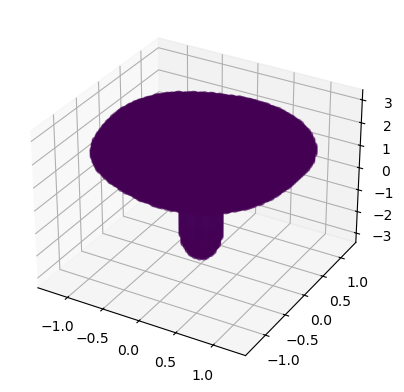

In [5]:
# Define the grid
x = torch.linspace(-3, 3, 100, device=device)
y = torch.linspace(-3, 3, 100, device=device)
z = torch.linspace(-3, 3, 100, device=device)

# Initialize the volume to zero
volume = torch.zeros((len(x), len(y), len(z)), device=device)

# Add each Gaussian to the volume
for params in all_params:
    mux, muy, muz, sx, sy, sz, rho_xy, rho_xz, rho_yz = params
    gaussian = gaussian_3d(x, y, z, mux, muy, muz, sx, sy, sz, rho_xy, rho_xz, rho_yz)
    volume += gaussian

# Convert volume to numpy for visualization
volume_np = volume.cpu().numpy()

# Plotting the volume using a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Threshold for visualization
threshold = 0.1
voxels = np.where(volume_np > threshold)

ax.scatter(x.cpu().numpy()[voxels[0]], y.cpu().numpy()[voxels[1]], z.cpu().numpy()[voxels[2]], c=volume_np[voxels], cmap='viridis', marker='o', alpha=0.5)

plt.show()

In [6]:
# Extract mean values
mux = [params[0] for params in all_params]
muy = [params[1] for params in all_params]
muz = [params[2] for params in all_params]

In [7]:
import plotly.graph_objects as go

# Create a 3D scatter plot
fig = go.Figure()

# Plot trunk points
fig.add_trace(go.Scatter3d(
    x=[params[0] for params in trunk_params],
    y=[params[1] for params in trunk_params],
    z=[params[2] for params in trunk_params],
    mode='markers',
    marker=dict(size=5, color='brown'),
    name='Trunk'
))

# Plot leaf points
fig.add_trace(go.Scatter3d(
    x=[params[0] for params in leaves_params],
    y=[params[1] for params in leaves_params],
    z=[params[2] for params in leaves_params],
    mode='markers',
    marker=dict(size=3, color='green'),
    name='Leaves'
))

# Update layout for better visualization and custom size
fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    title="Interactive 3D Tree Model",
    width=800,  # Width in pixels
    height=800  # Height in pixels
)

# Show the plot
fig.show()

In [10]:
import plotly.graph_objs as go
import random
import time
from IPython.display import display, clear_output

# Initialize the figure
fig = go.Figure()

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    title="Interactive 3D Tree Model",
    width=800,  # Width in pixels
    height=800  # Height in pixels
)

# Set initial data
fig.add_trace(go.Scatter3d(
    x=[],
    y=[],
    z=[],
    mode='markers',
    marker=dict(size=5, color='red')
))

# Function to add a random point
def add_random_point():
    # Generate random coordinates
    x = random.uniform(-1, 1)
    y = random.uniform(-1, 1)
    z = random.uniform(-1, 1)
    
    # Append the new point to the existing data
    fig.data[0].x += (x,)
    fig.data[0].y += (y,)
    fig.data[0].z += (z,)

# Continuously add points and update the plot
for _ in range(10):  # Add 10 points as an example
    add_random_point()
    clear_output(wait=True)  # Clear previous output
    display(fig)  # Display the updated figure
    time.sleep(1)  # Wait for 1 second before adding the next point

